# Impact of hidden states on QRBM

In [421]:
import pyquil.api as api
from pyquil import Program
from qRBM_final import qRBM
from pyquil.gates import *
from random import *
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss 
from sklearn import svm
from sklearn.neural_network import BernoulliRBM

In [246]:
def train_classical(num_epochs=20, num_hidden=2):
    model = BernoulliRBM(n_components=num_hidden, n_iter=num_epochs)
    model.fit(artificial_data)
    return model

In [247]:
def train(num_epochs=20, num_hidden=2, gate_noise_probs=None, meas_noise_probs=None, n_quantum_measurements=None):
    '''
    gate_noise_probs:       PX, PY, PZ gates getting applied to each qubit after every gate application
    meas_noise_probs:       PX, PY, PZ gates getting applied to the qubit being measured before it is measured
    n_quantum_measurements: None means "analytical" measurement to save time on simulation

    '''
    qvm = api.QVMConnection(gate_noise=gate_noise_probs, measurement_noise=meas_noise_probs)
    qr = qRBM(qvm, num_visible=4, num_hidden=num_hidden, n_quantum_measurements=n_quantum_measurements)
    qr.train(artificial_data, n_epochs=num_epochs)
    return qr, max_prob_list(qr.pred_list)

In [685]:
def max_prob_list(pred_list):
    max_prob_list = []
    for epoch_pred in pred_list:
        max_prob_list.append(np.max(epoch_pred))
    return max_prob_list

In [588]:
def plot_score(score_list, hidden_state):
    plt.plot(score_list, marker='o', label="Hidden State: " + str(hidden_state))
    # plt.ylim(0, 1)
    plt.xlabel('# Epochs')
    plt.ylabel('Accuracy')
    plt.title('Hidden States: Accuracy vs Epochs') 
    plt.legend()
    plt.ylim(0, 1.1)

In [251]:
def show_probs(qr):
    transformed = qr.transform(artificial_data)

    comparison = np.stack((transformed, random_coin))

    #compare our rbm probabilities with the coin flips.
    print('RBM Pr. | Original Coin Value')
    # print '-'*20
    for i in range(len(transformed)):
        print('{: 0.3f}'.format(float(comparison[:,i][0])), ' |', '{: 0.3f}'.format(comparison[:,i][1]))

In [252]:
def plot_prob_lists(prob_list, noise_probs_list, noise_type='gate'):
    fig, ax = plt.subplots(figsize=(10,6))
    for epoch, prob in enumerate(prob_list):
        ax.plot(prob, label=str(noise_probs_list[epoch]), marker=epoch+6)
    ax.legend()
    ax.set_title('Probabilities for different ' + noise_type + ' noise settings')

In [253]:
def evaluate_hidden_states(num_epochs, num_hidden_list, n_quantum_measurements):
    prob_list = []
    model_list = []
    for num_hidden in num_hidden_list:
        model, prob = train(num_epochs=num_epochs, 
                            num_hidden=num_hidden,
                            n_quantum_measurements=n_quantum_measurements)
        prob_list.append(prob)
        model_list.append(model)
    return prob_list, model_list

In [254]:
def evaluate_hidden_states_classical(num_epochs, num_hidden_list):
    prob_list = []
    model_list = []
    for num_hidden in num_hidden_list:
        prob = []
        for epoch in range(num_epochs):
            model = BernoulliRBM(n_components=num_hidden, n_iter=epoch)
            model.fit(artificial_data)
            prob.append(model.transform(artificial_data))
        prob_list.append(prob)
        model_list.append(model)
    return prob_list, model_list

In [255]:
def evaluate_noise(num_epochs, n_quantum_measurements, noise_probs_list, noise_type='gate', ):
    prob_list = []
    model_list = []
    for noise_probs in noise_probs_list:
        if noise_type == 'gate':
            model, prob = train(num_epochs=num_epochs, 
                                     gate_noise_probs=noise_probs,
                                     n_quantum_measurements=n_quantum_measurements)
        if noise_type == 'meas':
            model, prob = train(num_epochs=num_epochs, 
                                     meas_noise_probs=noise_probs,
                                     n_quantum_measurements=n_quantum_measurements)
            
        prob_list.append(prob)
        model_list.append(model)
    return prob_list, model_list

In [593]:
def classical_rbm_eval(num_epochs, classical_prob_list, hidden_state):
    y = random_coin
    scores = []
    for epoch in range(num_epochs):
        X = classical_prob_list[hidden_state][epoch]
        clf = svm.SVC()
        clf.fit(X, y)
        scores.append(clf.score(X,y))
    return scores

In [575]:
def quantum_rbm_eval(num_epochs, hidden_model_list, hidden_state):
    y = random_coin
    scores = []
    for epoch in range(num_epochs):
        X = hidden_model_list[hidden_state].pred_list[epoch]
        clf = svm.SVC()
        clf.fit(X, y)
        scores.append([clf.score(X,y)])
    return scores

## Creating the underlying distribution
We flip an unbiased coin to generate a sequence of random bits, this will be the underlying hidden distribution of our data.

In [658]:
#flip a coin
np.random.seed(1234)
random_coin = np.random.choice(np.arange(0,8), size=20, replace=True)
random_coin

array([7, 3, 6, 5, 4, 4, 0, 1, 7, 1, 7, 1, 2, 6, 3, 6, 4, 4, 2, 6, 2, 0,
       0, 4, 5, 0, 1, 7, 6, 6, 7, 2, 0, 3, 4, 5, 2, 6, 2, 3, 7, 3, 0, 1,
       3, 0, 3, 2, 3, 4, 1, 3, 3, 3, 2, 1, 6, 3, 7, 4, 2, 3, 6, 4])

## Generating encoded sequences

In [659]:
#Encode this coin flip in to an artifically high dimensional dataset
artificial_data = []
for flip in random_coin:
    if flip == 0:
        artificial_data.append([0,0,0,0])
    elif flip == 1:
        artificial_data.append([0,0,0,1])
    elif flip == 2:
        artificial_data.append([0,0,1,0])
    elif flip == 3:
        artificial_data.append([0,0,1,1])
    elif flip == 4:
        artificial_data.append([0,1,0,0])
    elif flip == 5:
        artificial_data.append([0,1,0,1])
    elif flip == 6:
        artificial_data.append([0,1,1,0])
    elif flip == 7:
        artificial_data.append([0,1,1,1])
    elif flip == 8:
        artificial_data.append([1,0,0,0])
    elif flip == 9:
        artificial_data.append([1,0,0,1])
    elif flip == 10:
        artificial_data.append([1,0,1,0])
    elif flip == 11:
        artificial_data.append([1,0,1,1])
    elif flip == 12:
        artificial_data.append([1,1,0,0])
    elif flip == 13:
        artificial_data.append([1,1,0,1])
    elif flip == 14:
        artificial_data.append([1,1,1,0])
    else:
        artificial_data.append([1,1,1,1])

#We know have an artificially high dimensional dataset that still only has the 1 bit coin flip dictating
#the underlying distribution
artificial_data = np.asarray(artificial_data)
artificial_data.shape

(64, 4)

## Experiment Settings

In [678]:
num_epochs = 5
num_hidden_list = [1, 2, 3]

### Quantum: Adding hidden states does not help

In [679]:
%%capture
hidden_prob_list, hidden_model_list = evaluate_hidden_states(num_epochs=num_epochs, 
                                                      num_hidden_list=num_hidden_list, 
                                                      n_quantum_measurements=None,)

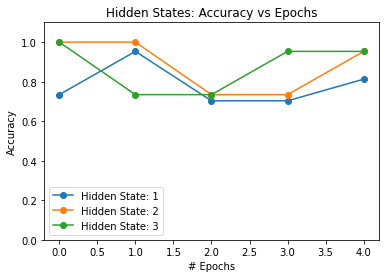

In [681]:
plot_score(quantum_rbm_eval(num_epochs, hidden_model_list, 0), 1)
plot_score(quantum_rbm_eval(num_epochs, hidden_model_list, 1), 2)
plot_score(quantum_rbm_eval(num_epochs, hidden_model_list, 2), 3)

### Comparison with Classical RBM

In [682]:
classical_prob_list, classical_model_list = evaluate_hidden_states_classical(num_epochs, num_hidden_list)

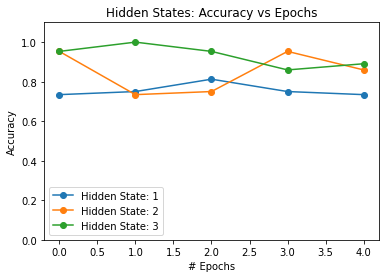

In [684]:
plot_score(classical_rbm_eval(num_epochs, classical_prob_list, 0), 1)
plot_score(classical_rbm_eval(num_epochs, classical_prob_list, 1), 2)
plot_score(classical_rbm_eval(num_epochs, classical_prob_list, 2), 3)